<a href="https://colab.research.google.com/github/jmfn098/transformer/blob/master/2heads_256batch_Trueshuffle_dataset1_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation con Redes Transformer

![Red Transformer](https://drive.google.com/uc?export=view&id=1nHAZ3WDsXYZuSPYximLx-hLa2S1zv9Cg)

In [1]:
pip install keras-transformer

  Created wheel for keras-transformer: filename=keras_transformer-0.39.0-cp37-none-any.whl size=12841 sha256=0c268575293fcd62c6997213885fdc3b3a9e7c0105fc054533f30dd16bfc26ad
  Stored in directory: /root/.cache/pip/wheels/77/42/35/d33c5907bca04ac5742e9eceefb644b680286de26728506a70
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.12.0-cp37-none-any.whl size=7471 sha256=60bcc91ac013418098e1d2a7ac90b7a8d9e8e9f89d93a117c0a21b1c9ab55762
  Stored in directory: /root/.cache/pip/wheels/36/d8/36/06ed09215806dca9ff504d8c0dda5da68d7f2c67d34a231d82
  Created wheel for keras-multi-head: filename=keras_multi_head-0.28.0-cp37-none-any.whl size=15559 sha256=2214aa9eeecb00c3ceee2d3aaf3e5fa3f5fa93555f13b9aaf9e0c04013e24fe4
  Stored in directory: /root/.cache/pip/wheels/ec/92/bd/b3407bc29501f7e28eb970a6c425a9a375485c5d8197df6a8f
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.15.0-cp37-none-any.whl size=5224 sha256=4b34e5a4662058b65f2c4dcbfcf5eb5aa65ec0ab3e

In [2]:
import numpy as np
import os
os.environ['TF_KERAS'] = '1'
from keras_transformer import get_model, decode
from pickle import load
#from google.colab import drive
np.random.seed(0)

In [16]:
os.listdir('/content/drive/MyDrive/Colab Notebooks (1)')

['data_retrieve.ipynb',
 'english-spanish.pkl',
 'dataset.npy',
 'tp',
 '2heads_50batch_trueshuffle_dataset1_9.ipynb']

In [17]:
# Leer set de entrenamiento
#drive.mount('/content/drive')
filename = '/content/drive/MyDrive/Colab Notebooks (1)/dataset.npy'

dataset = np.load(filename)
print(dataset[120000,0])
print(dataset[120000,1])

litre
litro


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# Crear "tokens"
source_tokens = []
for sentence in dataset[:,0]:
  source_tokens.append(sentence.split(' '))
print(source_tokens[120000])

target_tokens = []
for sentence in dataset[:,1]:
  target_tokens.append(sentence.split(' '))
print(target_tokens[120000])

['litre']
['litro']


In [19]:
def build_token_dict(token_list):
  token_dict = {
      '<PAD>': 0,
      '<START>': 1,
      '<END>': 2
  }
  for tokens in token_list:
    for token in tokens:
      if token not in token_dict:
        token_dict[token] = len(token_dict)
  return token_dict

In [20]:
source_token_dict = build_token_dict(source_tokens)
target_token_dict = build_token_dict(target_tokens)
target_token_dict_inv = {v:k for k,v in target_token_dict.items()}

print(len(source_token_dict))
print(len(target_token_dict))
print(len(target_token_dict_inv))

95532
110263
110263


In [21]:
len(source_token_dict)

95532

In [22]:
# Agregar start, end y pad a cada frase del set de entrenamiento
encoder_tokens = [['<START>'] + tokens + ['<END>'] for tokens in source_tokens]
decoder_tokens = [['<START>'] + tokens + ['<END>'] for tokens in target_tokens]
output_tokens = [tokens + ['<END>'] for tokens in target_tokens]

source_max_len = max(map(len, encoder_tokens))
target_max_len = max(map(len, decoder_tokens))

encoder_tokens = [tokens + ['<PAD>']*(source_max_len-len(tokens)) for tokens in encoder_tokens]
decoder_tokens = [tokens + ['<PAD>']*(target_max_len-len(tokens)) for tokens in decoder_tokens]
output_tokens = [tokens + ['<PAD>']*(target_max_len-len(tokens)) for tokens in output_tokens ]

In [23]:
print(encoder_tokens[120000])

['<START>', 'litre', '<END>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [24]:
encoder_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in encoder_tokens]
decoder_input = [list(map(lambda x: target_token_dict[x], tokens)) for tokens in decoder_tokens]
output_decoded = [list(map(lambda x: [target_token_dict[x]], tokens)) for tokens in output_tokens]

print(encoder_input[120000])

[1, 53982, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
# Crear la red transformer
model = get_model(
    token_num = max(len(source_token_dict),len(target_token_dict)),
    embed_dim = 32,
    encoder_num = 2,
    decoder_num = 2,
    head_num = 2,
    hidden_dim = 128,
    dropout_rate = 0.05,
    use_same_embed = False,
)
model.compile('adam', 'sparse_categorical_crossentropy')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder-Input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder-Token-Embedding (Embedd [(None, None, 32), ( 3528416     Encoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Embedding (TrigPosEmbed (None, None, 32)     0           Encoder-Token-Embedding[0][0]    
__________________________________________________________________________________________________
Encoder-1-MultiHeadSelfAttentio (None, None, 32)     4224        Encoder-Embedding[0][0]          
____________________________________________________________________________________________

In [ ]:
#from keras.callbacks import ModelCheckpoint
#from sklearn.model_selection import train_test_split

In [32]:
#    Entrenamiento
#x = np.hstack((np.array(encoder_input), np.array(decoder_input)))
#y = np.array(output_decoded)
#x_trainNP,x_testNP,y_train,y_test=train_test_split(x,y,test_size=0.2)
#x_train=[x_trainNP[:,0:49],x_trainNP[:,49:]]
#X_test=[x_testNP[:,0:49],x_testNP[:,49:]]
x = [np.array(encoder_input), np.array(decoder_input)]
y = np.array(output_decoded)
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/tp'
output_path = os.path.join(DATA_PATH,'output2')
if not os.path.exists(output_path):
    os.makedirs(output_path)
filename = os.path.join(output_path)
#checkpoint = ModelCheckpoint(filepath=filename, monitor='loss', verbose=1,
#    save_best_only=True, mode='auto', save_freq=1)

history=model.fit(x,y, epochs=15, batch_size=256,validation_split=0.1)

#filename = '/content/drive/My Drive/videos/2020-07-06/translator.h5'
#model.load_weights(filename)

Epoch 1/15
832/832 [==============================] - 1084s 1s/step - loss: 0.5935 - val_loss: 0.5770
Epoch 2/15
832/832 [==============================] - 1069s 1s/step - loss: 0.4181 - val_loss: 0.4808
Epoch 3/15
832/832 [==============================] - 1023s 1s/step - loss: 0.3527 - val_loss: 0.4241
Epoch 4/15
832/832 [==============================] - 1030s 1s/step - loss: 0.3059 - val_loss: 0.3939
Epoch 5/15
832/832 [==============================] - 1026s 1s/step - loss: 0.2698 - val_loss: 0.3780
Epoch 6/15
832/832 [==============================] - 1070s 1s/step - loss: 0.2407 - val_loss: 0.3684
Epoch 7/15
832/832 [==============================] - 1024s 1s/step - loss: 0.2163 - val_loss: 0.3607
Epoch 8/15
832/832 [==============================] - 1030s 1s/step - loss: 0.1948 - val_loss: 0.3612
Epoch 9/15
832/832 [==============================] - 1027s 1s/step - loss: 0.1761 - val_loss: 0.3644
Epoch 10/15
832/832 [==============================] - 1070s 1s/step - loss: 0.159

dict_keys(['loss', 'val_loss'])


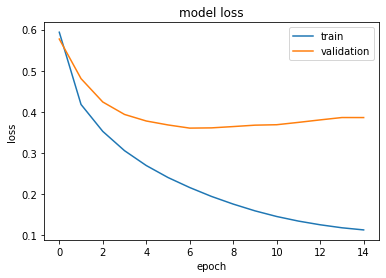

In [33]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [35]:

def translate(sentence):
  sentence_tokens = [tokens + ['<END>', '<PAD>'] for tokens in [sentence.split(' ')]]
  tr_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in sentence_tokens][0]
  decoded = decode(
      model, 
      tr_input, 
      start_token = target_token_dict['<START>'],
      end_token = target_token_dict['<END>'],
      pad_token = target_token_dict['<PAD>']
  )

  print('Frase original: {}'.format(sentence))
  print('Traducción: {}'.format(' '.join(map(lambda x: target_token_dict_inv[x], decoded[1:-1]))))

In [36]:
translate('the day is warm and sunny')

Frase original: the day is warm and sunny
Traducción: el dia esta caliente y el sol


In [37]:
translate('i am tired of college')

Frase original: i am tired of college
Traducción: estoy cansado de la universidad


In [39]:
a='why this net doesnt work Right'
a=a.lower()
translate(a)
model.save("/content/drive/MyDrive/Colab Notebooks (1)/tp/2heads_512batch_trueshuffle_dataset1.9")

Frase original: why this net doesnt work right
Traducción: esta visitado esta ensenando aqui el trabajo


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks (1)/tp/2heads_512batch_trueshuffle_dataset1.9/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks (1)/tp/2heads_512batch_trueshuffle_dataset1.9/assets
